In [1]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

def calculate_metrics(true_values, pred_values):
    mse = round(mean_squared_error(true_values, pred_values),3)
    mae = round(mean_absolute_error(true_values, pred_values),3)
    r_score = round(r2_score(true_values, pred_values),3)

    return {"mse": mse,
            "mae": mae,
            "r_score": r_score,}

In [92]:
import pandas as pd
import os
import sys
sys.path.insert(0, r'C:\work\DrugDiscovery\main_git\XAI_Chem')

from ml_part.random_forest.data_prep.preparation import DataPreparation
from ml_part.random_forest.train import RFTrain

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from hyperopt import space_eval

CSV_PATH = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\remained_features_25.01.csv'
smiles_filepath = r'C:\work\DrugDiscovery\main_git\XAI_Chem\data\updated_features\smiles_to_index.pkl'

dataPreparation = DataPreparation(CSV_PATH)
outliers_features_to_skip = ['dipole_moment']
X, y = dataPreparation.prepare_data_for_RF(is_pKa=True,
                                           use_mandatory_features=True,
                                           is_remove_outliers=True,
                                           is_remove_nan=False,
                                           outliers_features_to_skip=outliers_features_to_skip)

features_to_drop = []
for feature_name in X.columns:
    # if "angle" in feature_name.lower() or feature_name in outliers_features_to_skip:
    if "angle" in feature_name.lower():
        features_to_drop.append(feature_name)

X = X.drop(features_to_drop, axis=1)

rf_train = RFTrain(X=X, 
                   y=y,
                   smiles_filepath=smiles_filepath,
                   is_pKa=True,
                   k_folds=2)


True
183
['dipole_moment', 'FPSA3', 'nHRing', 'avg_atoms_in_cycle', 'angle_X1X2R2', 'PNSA5', 'nN', 'angle_R2X2R1', 'nF', 'nFRing', 'tpsa+f', 'f_freedom', 'f_atom_fraction', 'mol_num_cycles', 'nO', 'nFAHRing', 'angle_R1X1R2', 'distance_between_atoms_in_f_group_centers', 'nC', 'PBF', 'nAHRing', 'mol_volume', 'nFaRing', 'f_to_fg', 'GeomShapeIndex', 'cis/trans', 'PPSA5', 'nFHRing', 'angle_X2X1R1', 'nFaHRing', 'RPCS', 'naRing', 'nFARing', 'dihedral_angle', 'naHRing', 'chirality', 'nARing', 'TASA', 'pKa', 'logP']
FPSA3 [40]
PNSA5 [37, 38]
f_atom_fraction [124]
distance_between_atoms_in_f_group_centers [35]
PBF [40, 71, 127]
mol_volume [127]
logP [82, 83]
Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       173, 174, 175, 176, 177, 178, 179, 180, 181, 182],
      dtype='int64', length=183)
Remains rows:169, amount of features: 40


In [99]:
import joblib

model_path_for_rf = r'C:\work\DrugDiscovery\main_git\XAI_Chem\ml_part\random_forest\models_updated_features_train\pKa_rf_all_molecules(with_and_without_angles)_without_angles(as_features)_without_outliers(except_dipole_moment)_CV2.joblib'

model = joblib.load(model_path_for_rf)

In [94]:
model

RandomForestRegressor(max_depth=8, max_features=41, min_samples_leaf=3,
                      min_samples_split=7, n_estimators=39, random_state=42)

In [95]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

def calculate_crossval_metrics(X_train, y_train, model):

    cv_indices_dict = {0: [], 1: []}
    for index, row in X_train.iterrows():
        cv_indices_dict[row['fold_id']].append(index)
    cv_indices = [[cv_indices_dict[0], cv_indices_dict[1]], [cv_indices_dict[1], cv_indices_dict[0]]]

    mse, mae, r_score = 0, 0, 0

    for cv_index in range(len(cv_indices)):
        model_crossval = RandomForestRegressor(n_estimators=model.n_estimators, 
                                                max_depth=model.max_depth,
                                                max_features=model.max_features,
                                                min_samples_leaf=model.min_samples_leaf,
                                                min_samples_split=model.min_samples_split,
                                                random_state=42)
        train_cv_x = X_train.loc[cv_indices[cv_index][0]].drop(columns=['fold_id'])
        train_cv_y = y_train.loc[cv_indices[cv_index][0]]

        test_cv_x = X_train.loc[cv_indices[cv_index][1]].drop(columns=['fold_id'])
        test_cv_y = y_train.loc[cv_indices[cv_index][1]]
        model_crossval.fit(train_cv_x, train_cv_y)

        y_crossval_pred = model_crossval.predict(test_cv_x)
        
        mse += round(mean_squared_error(test_cv_y, y_crossval_pred),3)
        mae += round(mean_absolute_error(test_cv_y, y_crossval_pred),3)
        r_score += round(r2_score(test_cv_y, y_crossval_pred),3)

    return {"mse": round(mse / len(cv_indices),3),
            "mae": round(mae / len(cv_indices),3),
            "r_score": round(r_score / len(cv_indices),3),}

In [96]:
y_test = rf_train.y_test
X_test = rf_train.X_test

y_pred_test = model.predict(X_test)

y_train = rf_train.y_train
X_train = rf_train.X_train
print("cross-val metrics:", calculate_crossval_metrics(X_train, y_train, model))
X_train = X_train.drop(['fold_id'], axis=1)


y_pred_train = model.predict(X_train)

print("train metrics:", calculate_metrics(y_train, y_pred_train))
print("OOS metrics:", calculate_metrics(y_test, y_pred_test))

cross-val metrics: {'mse': 0.945, 'mae': 0.71, 'r_score': 0.853}
train metrics: {'mse': 0.189, 'mae': 0.319, 'r_score': 0.971}
OOS metrics: {'mse': 0.572, 'mae': 0.64, 'r_score': 0.905}


<BarContainer object of 33 artists>

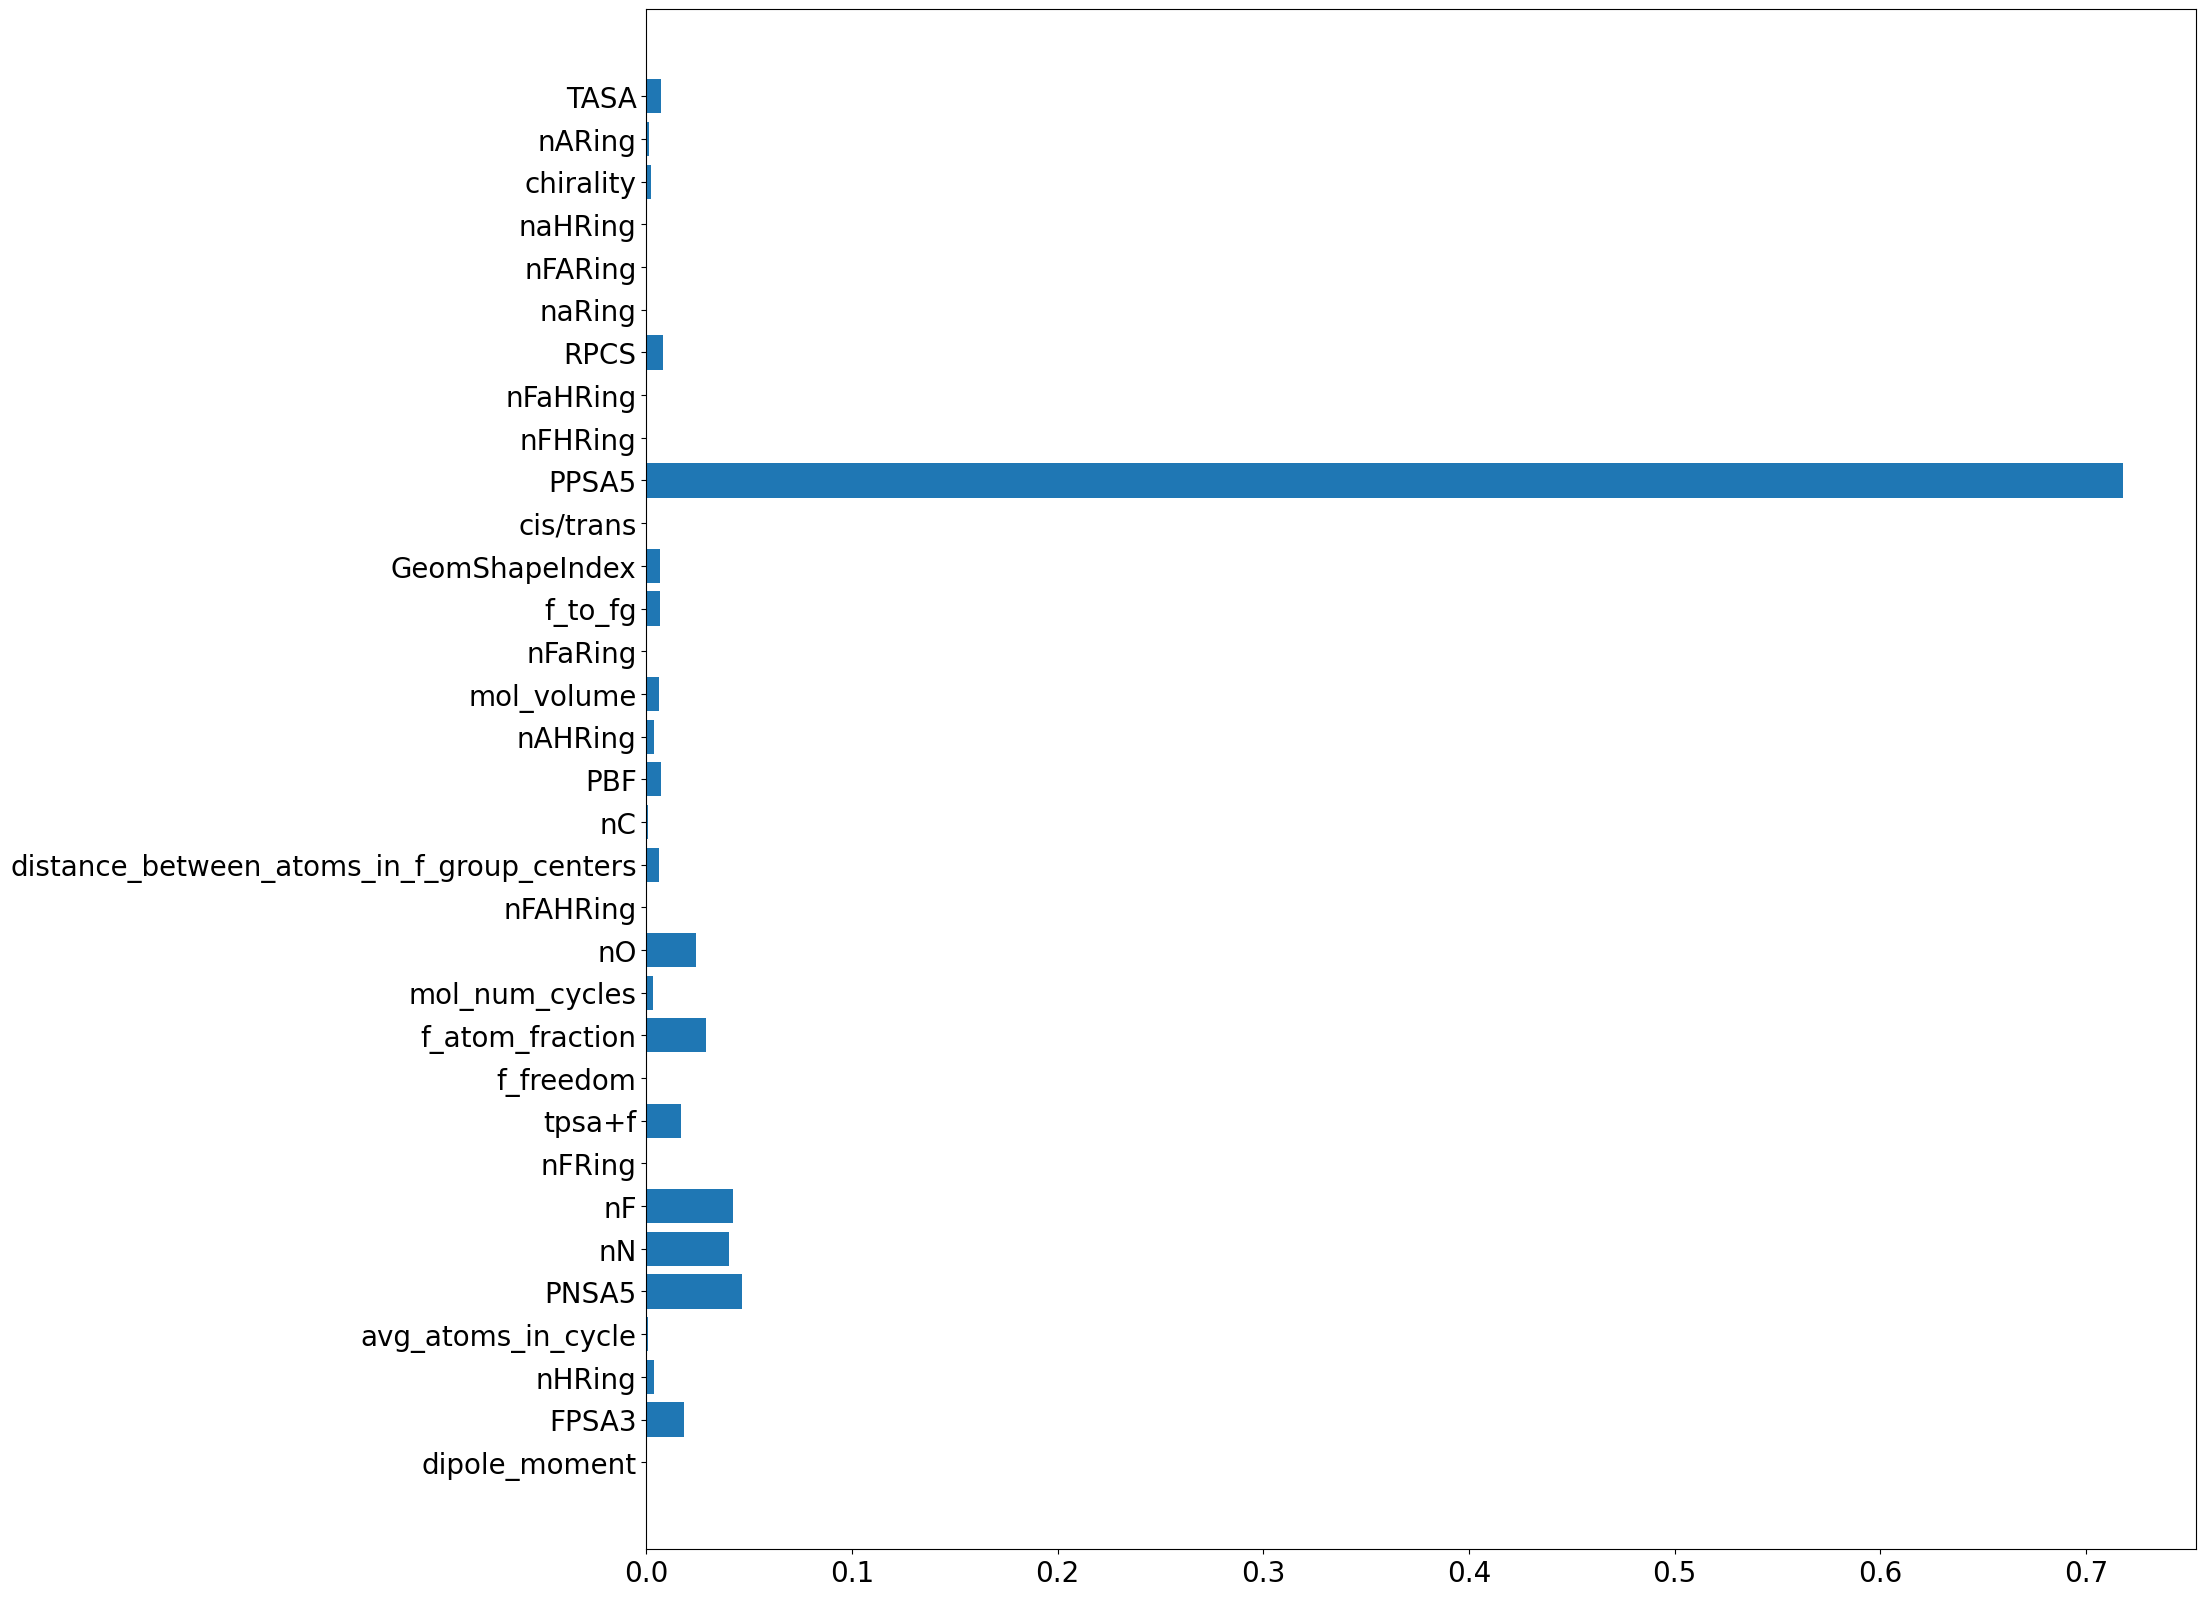

In [97]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(20,20))
plt.barh(X.columns, model.feature_importances_)

Text(0.5, 0, 'Random Forest Feature Importance')

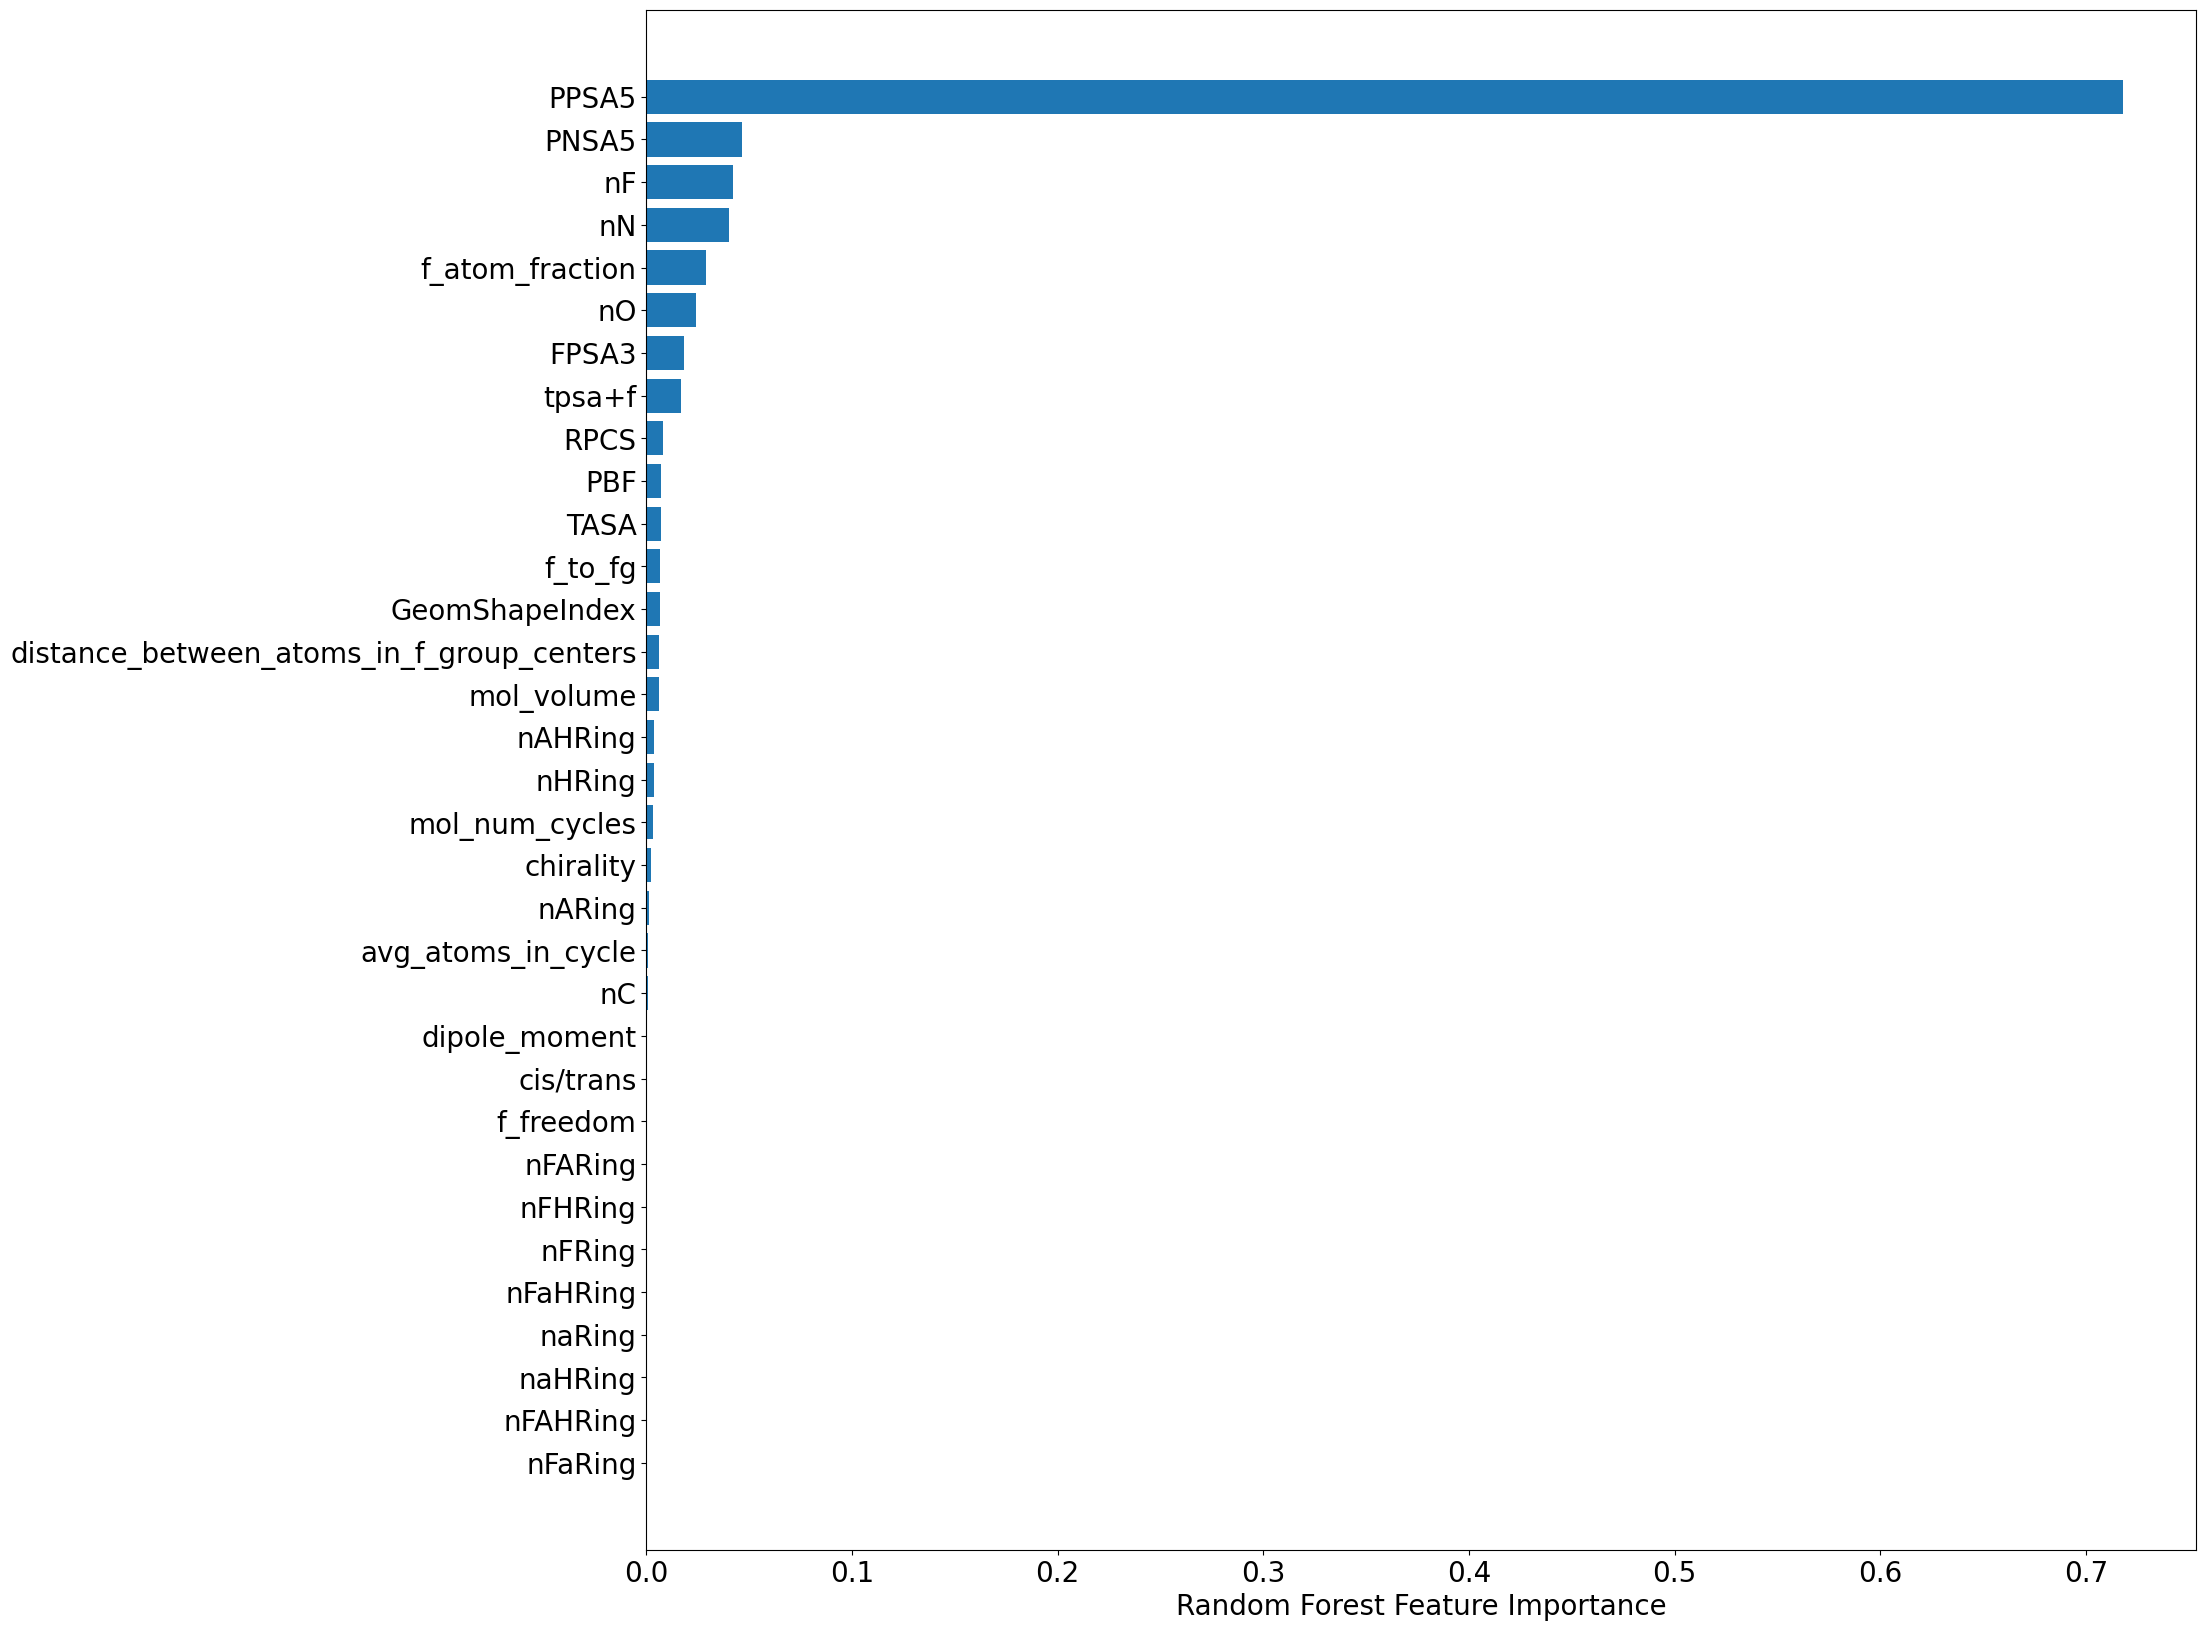

In [100]:
sorted_idx = model.feature_importances_.argsort()
plt.figure(figsize=(20,20))
plt.barh(X.columns[sorted_idx][::-1][:][::-1], model.feature_importances_[sorted_idx][::-1][:][::-1])
plt.xlabel("Random Forest Feature Importance")

PERMUTATION SCORE

Text(0.5, 0, 'Permutation Importance')

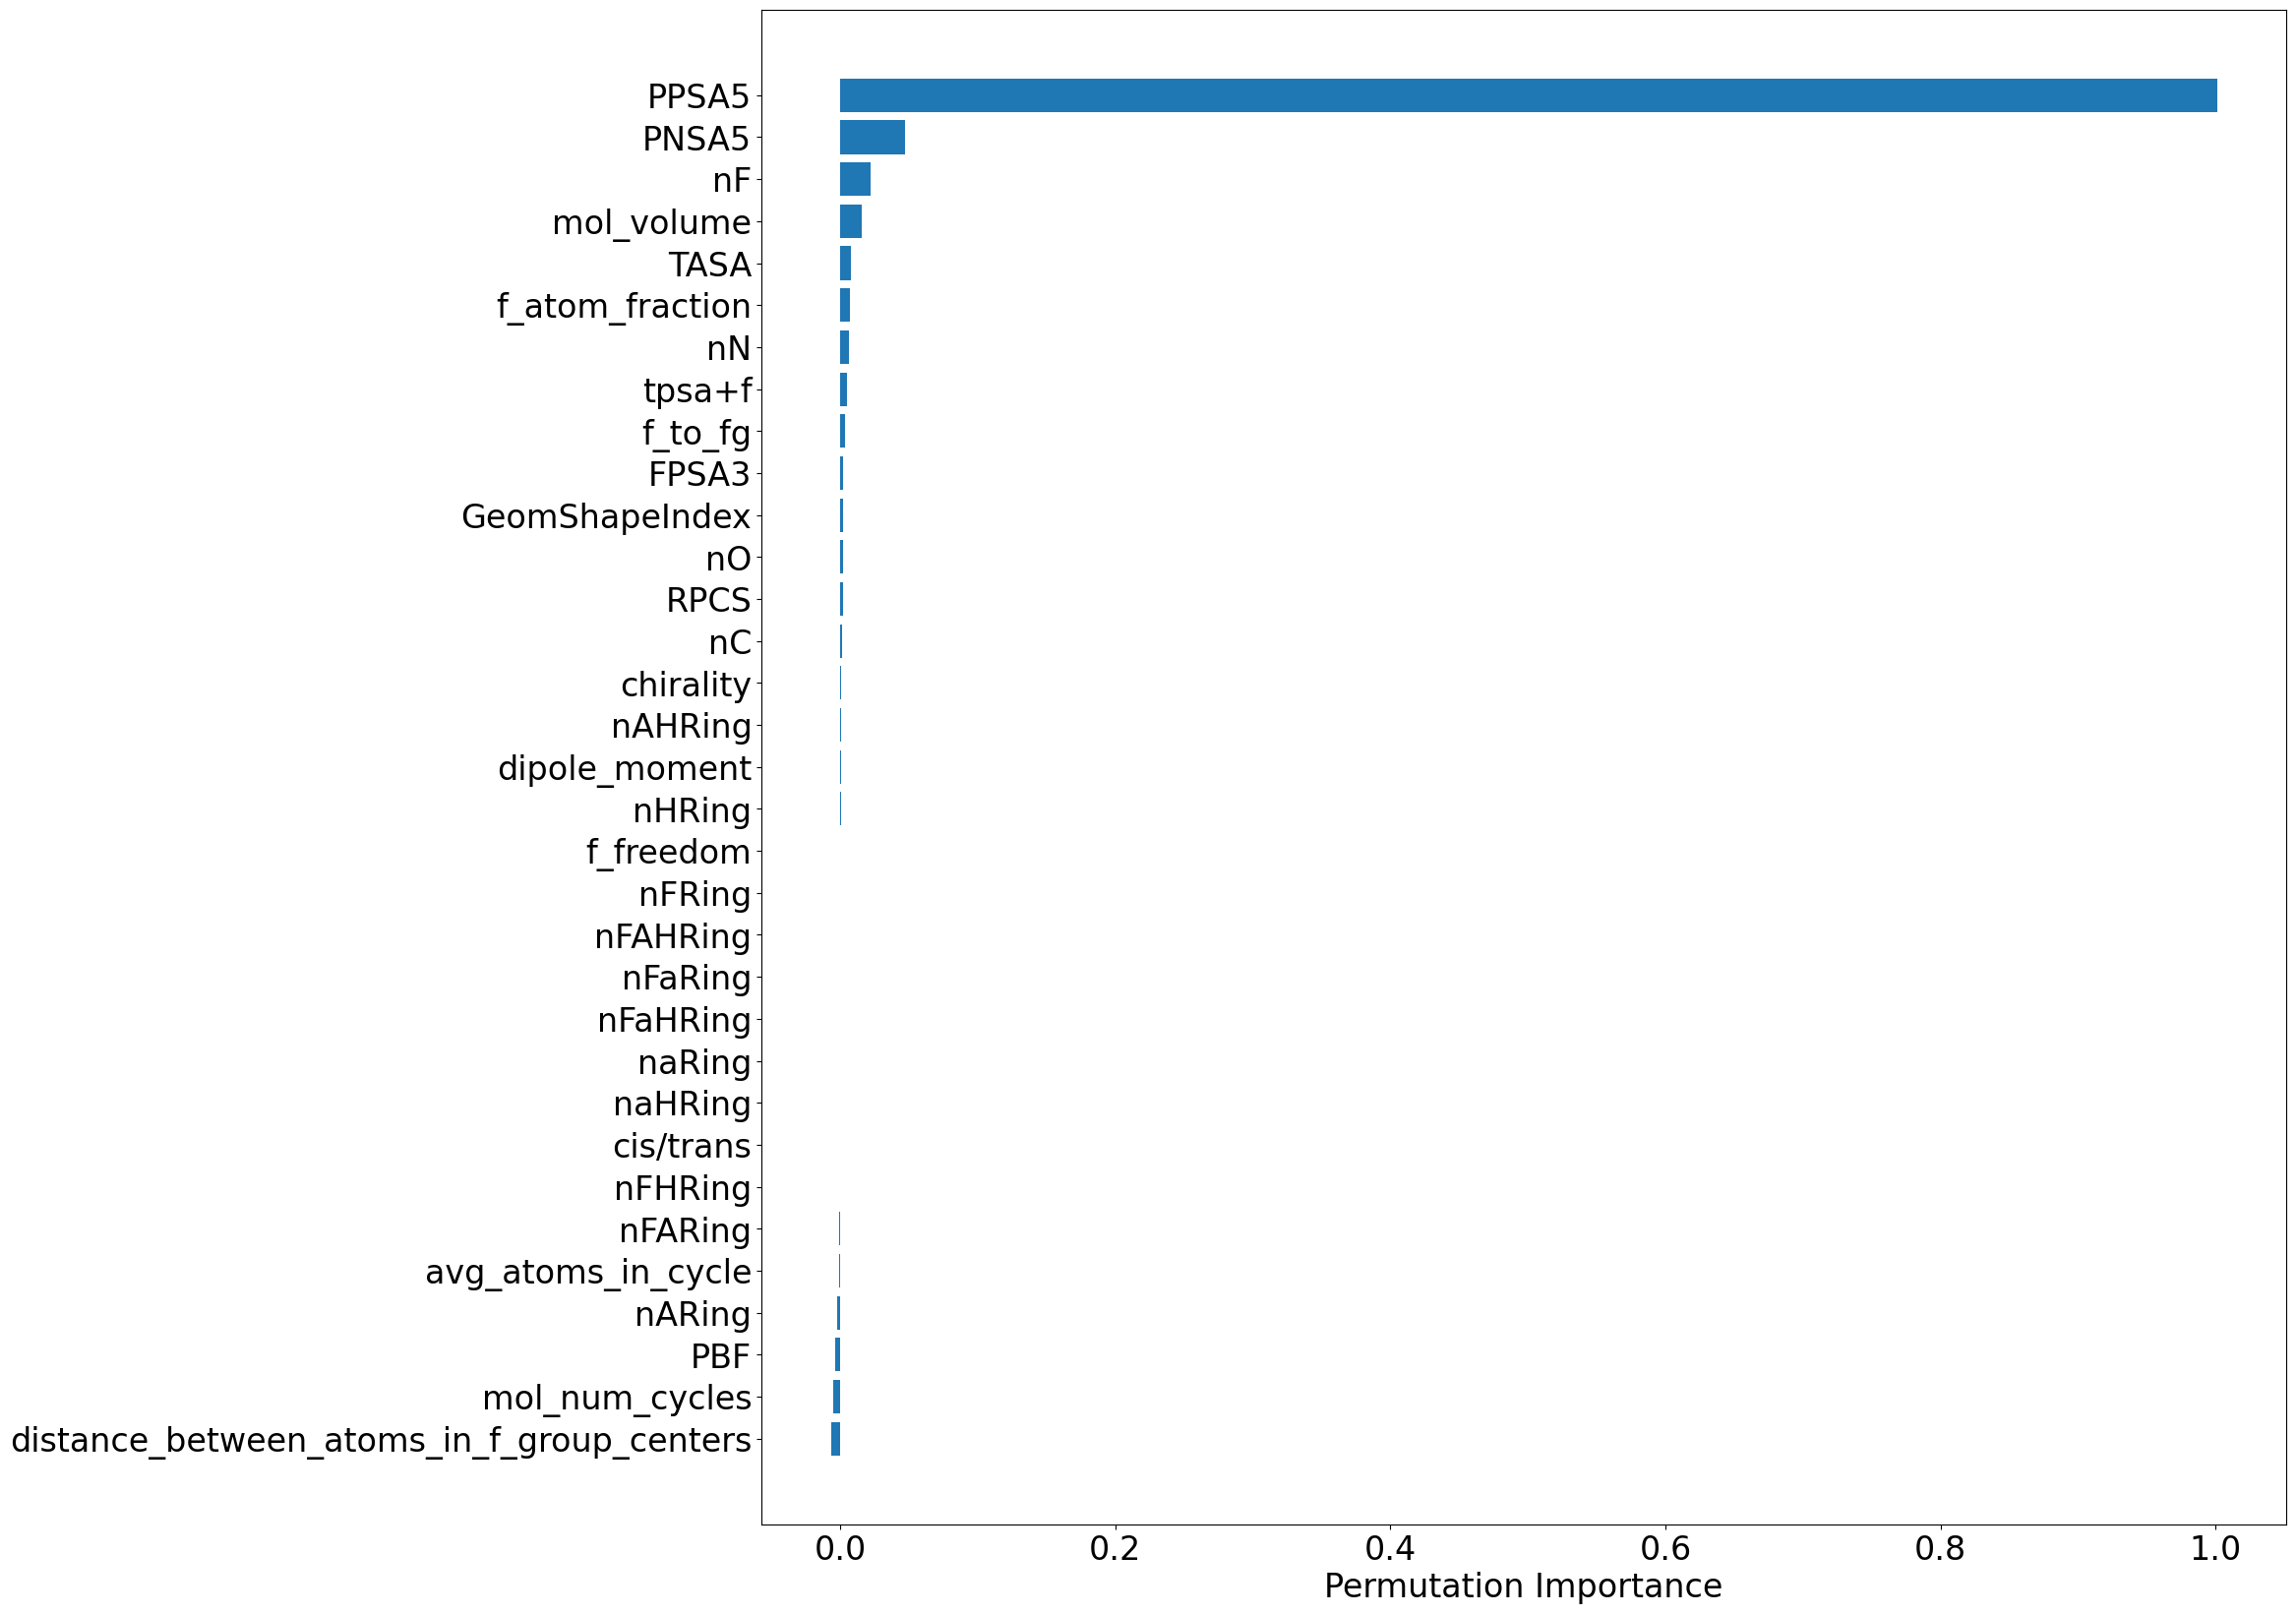

In [104]:
# fine tuned for more than hour
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model, X_test, y_test, n_repeats=2000)

sorted_idx = perm_importance.importances_mean.argsort()

plt.rcParams.update({'font.size': 24})
plt.figure(figsize=(20,20))
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

SHAP

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


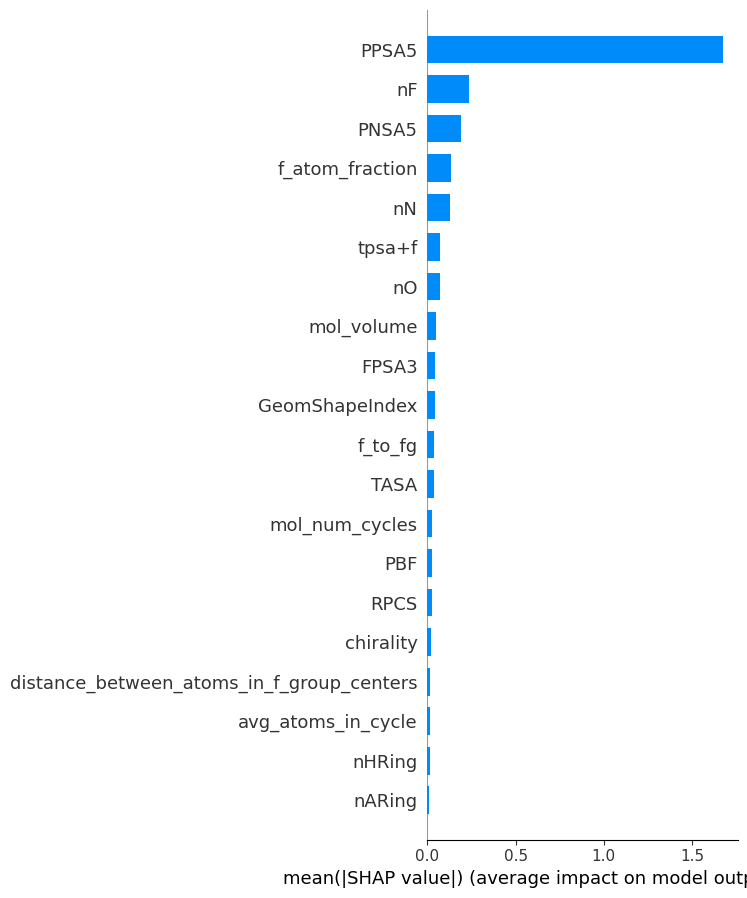

In [105]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")


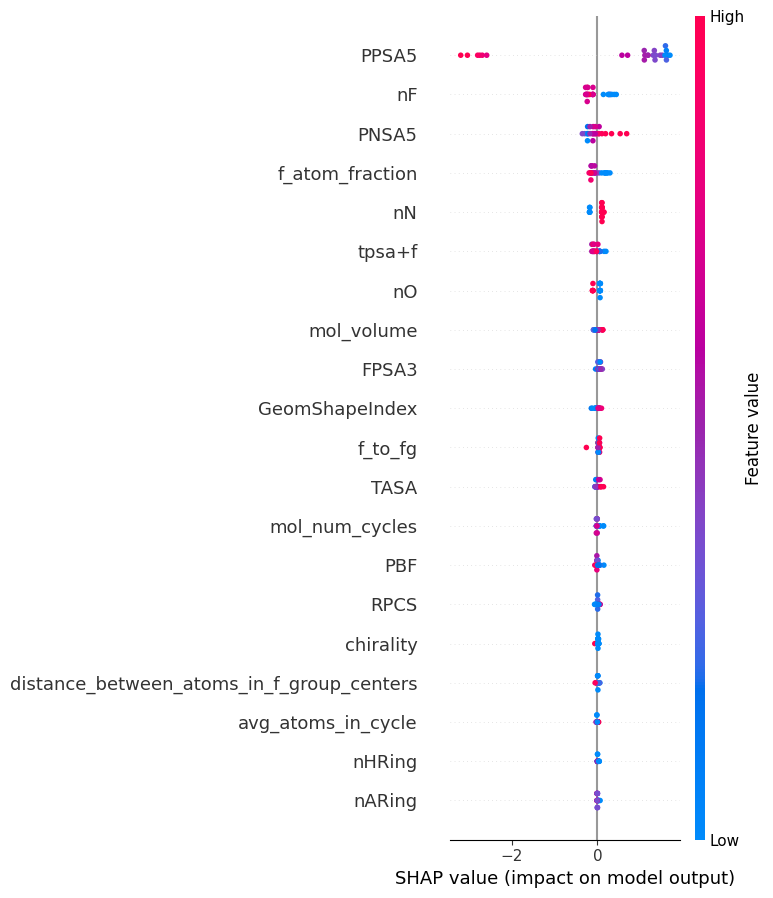

In [106]:
shap.summary_plot(shap_values, X_test)